In [1]:
# %%capture --no-stderr
# %pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:
import getpass
import os


In [3]:
from patra_agent.cypher_templates import patra_agent_template, patra_generation_template
from patra_agent.util import llm, graph, top_k_results

/Users/swithana/git/d2i/patra-agents/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Create Agents

The following helper functions will help create agents. These agents will then be nodes in the graph.

You can skip ahead if you just want to see what the graph looks like.

In [4]:
from langchain.agents import create_openai_functions_agent, AgentExecutor
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START

# 
def create_agent(llm, tools, template: str, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                template + "\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if tools is not None:
        prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
        return prompt | llm.bind_tools(tools)
    else:
        return prompt | llm

# def create_agent(llm, tools, template: str, system_message: str):
#     """Create an agent."""
#     prompt = ChatPromptTemplate.from_messages(
#         [
#             (
#                 "system",
#                 template +
#                 "\n{system_message}",
#             ),
#             MessagesPlaceholder(variable_name="messages"),
#             MessagesPlaceholder(variable_name="agent_scratchpad"),
#         ]
#     )
#     prompt = prompt.partial(system_message=system_message)
#     agent = create_openai_functions_agent(llm, tools, prompt)
#     executor = AgentExecutor(agent=agent, tools=tools)
#     return executor


## Define tools

We will also define some tools that our agents will use in the future

In [5]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)


# Tools for Patra
@tool
def execute_cypher(
        query: Annotated[str, "Cypher query to execute on the graph"],
) -> Annotated[str, "Result of the Cypher query execution"]:
    """Execute the given cypher query on the graph."""
    response = graph.query(query)[:top_k_results]
    query_result = str(response).replace("{", "{{").replace("}", "}}")
    print("+++++++++++++++++++++++")
    print(query_result)
    print("+++++++++++++++++++++++")
    print("+++++++++++++++++++++++")
    return query_result + " If you have completed all tasks, respond with FINAL ANSWER."


@tool
def print_hello(
        name: Annotated[str, "Name of the person"],
) -> Annotated[str, "Hello + name"]:
    """Returns hello name."""
    return str("Hello, {}!".format(name))



## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define State

We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [6]:
import operator
from typing import Annotated, Sequence, TypedDict, List

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define Agent Nodes

We now need to define the nodes. First, let's define the nodes for the agents.

In [7]:
from langchain_core.messages import AIMessage
import functools


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
        # state['messages'] = state['messages'] + [result]
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

def human_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = HumanMessage(content=result["output"], name=name)
        # state['messages'] = state['messages'] + [result]
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

# llm = ChatOpenAI(model="gpt-4-1106-preview")


# Patra agent
patra_agent = create_agent(
    llm,
    [print_hello],
    template=patra_agent_template,
    system_message="Return a single question in english for the Query Executor Agent",
)
patra_node = functools.partial(agent_node, agent=patra_agent, name="PatraAgent")

query_executor = create_agent(
    llm,
    [execute_cypher],
    template=patra_generation_template,
    system_message="Execute the query and return the results",
)
query_node = functools.partial(agent_node, agent=query_executor, name="QueryExecutor")

### Define Tool Node

We now define a node to run the tools

In [8]:
from langgraph.prebuilt import ToolNode

tools = [execute_cypher]
tool_node = ToolNode(tools)

### Define Edge Logic

We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [9]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if isinstance(last_message, ToolMessage) and last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

### Define the Graph

We can now put it all together and define the graph!

In [10]:
workflow = StateGraph(AgentState)

workflow.add_node("PatraAgent", patra_node)
workflow.add_node("QueryExecutor", query_node)
workflow.add_node("call_tool", tool_node)

# workflow.add_edge("call_tool", "PatraAgent")
# workflow.add_edge("QueryExecutor", "PatraAgent")
workflow.add_edge("QueryExecutor", "call_tool")
# workflow.add_edge("PatraAgent", "QueryExecutor")
workflow.add_edge("call_tool", "PatraAgent")
workflow.add_conditional_edges(
    "PatraAgent",
    router,
    {"continue": "QueryExecutor", "__end__": END},
)
# workflow.add_conditional_edges(
#     "QueryExecutor",
#     router,
#     {"continue": "PatraAgent"},
# )
# 
# workflow.add_conditional_edges(
#     "call_tool",
#     # Each agent node updates the 'sender' field
#     # the tool calling node does not, meaning
#     # this edge will route back to the original agent
#     # who invoked the tool
#     lambda x: x["sender"],
#     {
#         "PatraAgent": "PatraAgent",
#         "QueryExecutor": "QueryExecutor",
#     },
# )
workflow.add_edge(START, "PatraAgent")
# workflow.add_edge(START, "QueryExecutor")
# workflow.add_edge("QueryExecutor", END)
app = workflow.compile()

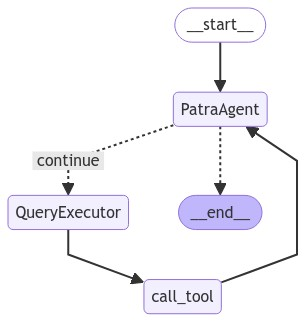

In [11]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
events = app.stream(
    {
        "messages": [
            HumanMessage(
                content="out of all the models deployed at edgeDevice with location griffy-lake, which one has the best CPU power consumption for deployments?"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)
for s in events:
    print(s)
    print("----")

{'PatraAgent': {'messages': [AIMessage(content='What are the models deployed at the edgeDevice with location griffy-lake?', response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 258, 'total_tokens': 275}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, name='PatraAgent', id='run-859ff6ee-514e-4c9a-a21d-c55ea1e89a95-0', usage_metadata={'input_tokens': 258, 'output_tokens': 17, 'total_tokens': 275})], 'sender': 'PatraAgent'}}
----
{'QueryExecutor': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_g9wPmYVrtHDuGRTiXMa2QQKl', 'function': {'arguments': '{"query":"MATCH (d:EdgeDevice {location: \'griffy-lake\'})-[r:EXECUTED_ON]-(e:Experiment)-[r2:USED]-(m:Model) RETURN DISTINCT m.model_id AS model_id"}', 'name': 'execute_cypher'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 993, 'total_tokens': 1055}, 'model_name